# Logisitc and exponential growth models of UK Covid-19 confirmed cases data

Date: 2020-04-16

Author: Andrew Lane

DISCLAIMER: I am not an epidemiologist or doctor. Just an curious guy with a laptop and access to some data. Do not use the contents of this notebook for anything.

In [1]:
from dataclasses import dataclass

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


font = {'size'   : 14}
matplotlib.rc('font', **font)

## Prepare data

The data used in this notebook come from a collated source on [GitHub](https://github.com/tomwhite/covid-19-uk-data)

In [2]:
SRC_DATA = ("https://raw.githubusercontent.com/tomwhite/covid-19-uk-data"
            "/master/data/covid-19-totals-uk.csv")

UK_POP = 63182000

In [3]:
df = (
    pd.read_csv(SRC_DATA)
    .assign(date=lambda df: pd.to_datetime(df['Date']))
    .drop(columns='Date')
    .set_index('date')
)

assert df.index.is_unique

In [4]:
df.head(10)

,Tests,ConfirmedCases,Deaths
date,,,
2020-01-25,31,0,0
2020-01-26,52,0,0
2020-01-27,73,0,0
2020-01-28,97,0,0
2020-01-29,130,0,0
2020-01-30,161,0,0
2020-01-31,177,2,0
2020-02-01,203,2,0
2020-02-02,266,2,0


Consider dates from the first confirmed case

In [5]:
df = df.loc['2020-01-31':]

Create a column `NumDaysSinceFirstCase` to report number of days since first confirmed case

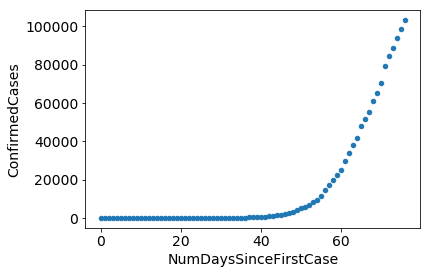

In [6]:
df = df.assign(NumDaysSinceFirstCase=range(len(df.index)))
df.plot.scatter(x='NumDaysSinceFirstCase', y='ConfirmedCases')

## Fit logistic growth model

Logistic function is defined by

$f(x) = \frac{a}{1 + e^{-k(x - x_0)}}$.

Our implementation:

In [7]:
def logistic_func(x: float, x0: float, a: float, k: float) -> float:
    """Logistic function.
    
    f(x) = \frac{a}{1 + e^{-k(x - x_0)}}
    
    Parameters
    ----------
    x0: x value of sigmoid midpoint
    a: curve's maximum value
    k: logistic growth rate
    """
    return a / (1 + np.exp(-k * (x - x0)))

logistic_func_v = np.vectorize(logistic_func, excluded=['x0', 'a', 'k'])

Test implementation of logistic function by checking a plot made using the function looks correct. We expect midpoint of curve to be at x=50 and the maximum point to be 5.

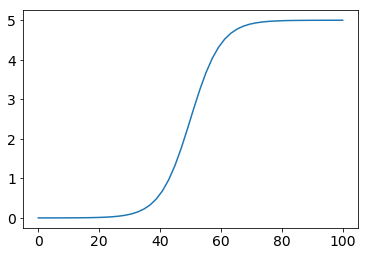

In [8]:
xx = np.linspace(0, 100)
yy = logistic_func_v(xx, x0=50, a=5, k=0.2)
plt.plot(xx, yy)

Find optimal model parameters to fit logistic growth model to predict the number of confirmed cases given the number of days since the first case.

In [9]:
(x0_opt, a_opt, k_opt), _ = curve_fit(logistic_func,
                                      df['NumDaysSinceFirstCase'],
                                      df['ConfirmedCases'])
print('x0_opt: ', x0_opt)
print('a_opt: ', a_opt)
print('k_opt: ', k_opt)

x0_opt:  68.90895413655875
a_opt:  133844.1206186678
k_opt:  0.1656379602626532


The above results indicate the best fit logistic growth model has the midpoint of the curve (the 'peak') being at 69 days after 2020-01-31, i.e 2020-04-09. It suggests the final number of infections will be 13,3844, and the logistic growth rate is 0.166.

Calculate values based on logistic growth model and plot against observed data

In [10]:
df = df.assign(logistic_model=lambda df: (
    logistic_func_v(df['NumDaysSinceFirstCase'], x0_opt, a_opt, k_opt)))

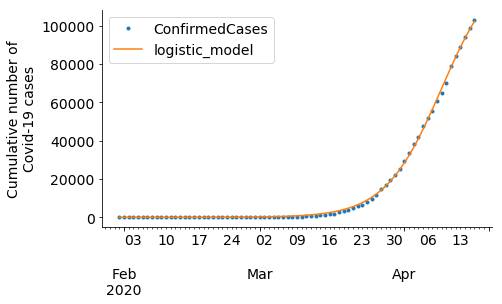

In [11]:
fig, ax = plt.subplots(figsize=(7, 4))
df[['ConfirmedCases', 'logistic_model']].plot(ax=ax, style=['.', '-'])
ax.set_ylabel('Cumulative number of\nCovid-19 cases');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(None);

The fit looks good. As this is not a linear model we can't report an $r^2$ value, so we report root mean square error ([RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)) instead.

In [12]:
def rmse(data: np.array, model: np.array) -> float:
    return np.sqrt(np.power(data - model, 2).sum() / data.size)

In [13]:
error = rmse(data=df['ConfirmedCases'].values,
             model=df['logistic_model'].values)

print(f'RMSE for logistic growth model is {round(error, 6)}, '
      f'or {round(error / UK_POP, 6) * 100}% of the UK population.')

RMSE for logistic growth model is 721.277752, or 0.0011% of the UK population.


In [14]:
print('New cases on 16th April: ', int(df['ConfirmedCases'].diff().loc['2020-04-16']))

New cases on 16th April:  4617


An RMSE of 721 seems quite large given the apparent goodness of fit. However, considering that the number of new cases on 16th April was 4617, an RMSE of ~16% of a day's change may not be too bad.

TODO: Read about model evaluation for logistic growth models. I suspect there is a better metric than RMSE.

# Fit exponential growth model

Given the logistic growth model suggests the midpoint of the curve, and therefore the maximum slope, will occur on 9th April, any exponential growth should be expected to end before that point.

The expression for exponential growth is [given by][wiki-exp-growth]

$$x(t) = x_0 \, (1 + r_{\tau})^{t/\tau}$$
where $r_{\tau}$ is the proportion by which $x$ increases in a time step of duration $\tau$. Setting $\tau = 1 \text{ day}$ and $r = r_{1 \text{ day}}$ we have

$$x(t) = x_0 \, (1 + r)^t$$
where $t$ is the number of days since the initial count taken at $x_0$. Taking logarithms of the above equation we can reformulate exponential growth as log-linear growth:

$$\log x(t) = \log x_0 + t \, \log(1 + r)\,.$$
Viewing the model like this, we see that exponential growth will appear as a straight line on a log-linear plot. That line's y-intercept will equal $\log x_0$, and its slope $\log(1 + r)$.

[wiki-exp-growth]: https://en.wikipedia.org/wiki/Exponential_growth#Basic_formula

Plot the UK confirmed cases data on log-linear axes to acertain if there is a period demonstrating exponential growth

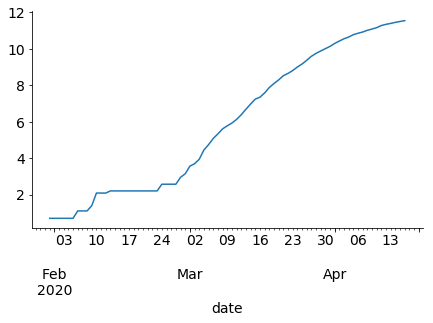

In [15]:
fig, ax = plt.subplots(figsize=(7, 4))
df.assign(log_cases=lambda df: np.log(df['ConfirmedCases']))['log_cases'].plot(ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

It looks to me like we saw exponential growth for the duration of March. The behaviour before the beginning of March is curious, but I don't have enough information to comment on why there appears to have been a plateau in mid-February. In any case we exclude dates before March as they don't correspond to the expected exponential growth pattern.

In [16]:
df_exp_growth = df['2020-03-01':'2020-03-31']

In [17]:
df_exp_growth.head()

,Tests,ConfirmedCases,Deaths,NumDaysSinceFirstCase,logistic_model
date,,,,,
2020-03-01,11750,35,0,30,212.309225
2020-03-02,13525,40,0,31,250.484256
2020-03-03,13911,51,0,32,295.508307
2020-03-04,16659,85,0,33,348.604225
2020-03-05,18083,114,0,34,411.210860


Create a new column containing $\log(\text{ConfirmedCases})$

In [18]:
df_exp_growth = (
    df_exp_growth.assign(log_ConfirmedCases=lambda df: (
        np.log(df['ConfirmedCases'])))
)

In [19]:
df_exp_growth.head()

,Tests,ConfirmedCases,Deaths,NumDaysSinceFirstCase,logistic_model,log_ConfirmedCases
date,,,,,,
2020-03-01,11750,35,0,30,212.309225,3.555348
2020-03-02,13525,40,0,31,250.484256,3.688879
2020-03-03,13911,51,0,32,295.508307,3.931826
2020-03-04,16659,85,0,33,348.604225,4.442651
2020-03-05,18083,114,0,34,411.210860,4.736198


Perform linear regression on the logged dependent variable

In [20]:
reg = LinearRegression().fit(
    df_exp_growth['NumDaysSinceFirstCase'].values.reshape(-1, 1),
    df_exp_growth['log_ConfirmedCases'].values
)

The linear model's intercept is $\log x_0$, and the slope (i.e coefficient value) is $\log(1 + r)$. Hence we find the optimal parameters as follows:

In [21]:
x0_opt = np.exp(reg.intercept_)
r_opt = np.exp(reg.coef_[0]) - 1

In [30]:
print(f'Optimal x0: {round(x0_opt, 3)}\nOptimal r: {round(r_opt, 3)}')

Optimal x0: 0.063
Optimal r: 0.248


I.e. from the optimal exponential growth model we infer that the number of infections increased at a rate of 25% per day.

In [22]:
def exp_func(t: float, x0: float, r: float) -> float:
    return x0 * np.power((1 + r), t)

exp_func_v = np.vectorize(exp_func, excluded=['x0', 'r'])

In [23]:
log_yy_true = np.log10(df_exp_growth['ConfirmedCases'])
log_yy_exp_model = np.log10(x0_opt) + df_exp_growth['NumDaysSinceFirstCase'] * np.log10(r_opt + 1)
exp_model_r2 = r2_score(log_yy_true, log_yy_exp_model)

In [24]:
exp_model_r2

0.9903149874858671

Plot log-linear model using parameters for the exponential model

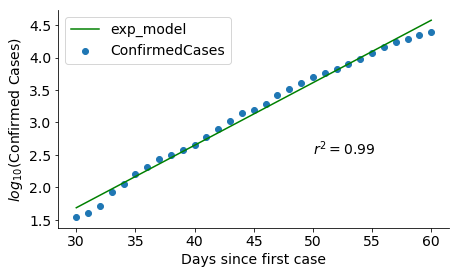

In [25]:
fig, ax = plt.subplots(figsize=(7, 4))
xx = df_exp_growth['NumDaysSinceFirstCase']
ax.scatter(xx,log_yy_true)
ax.plot(xx, log_yy_exp_model, ls='-', label='exp_model', c='g')
ax.set_ylabel(r'$log_{10}$(Confirmed Cases)')
ax.set_xlabel('Days since first case')
ax.annotate(r'$r^2 = 0.99$', (50, 2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend();

Calculate values predicted by the exponential model for each of the days in the dataset until 2020-03-31

In [26]:
df_exp_growth = df_exp_growth.assign(exp_model=lambda df: (
    exp_func_v(df['NumDaysSinceFirstCase'], x0_opt, r_opt)))

Join exponential model back to original df

In [27]:
df = df.join(df_exp_growth['exp_model'])

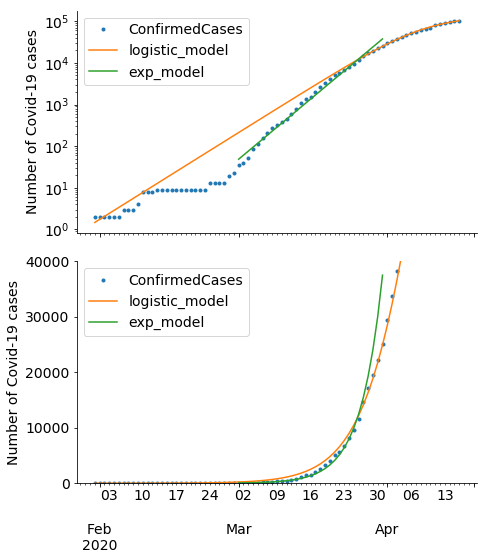

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 8), sharex=True)
plot_df = df[['ConfirmedCases', 'logistic_model', 'exp_model']]
plot_df.plot(ax=axes[0], style=['.', '-', '-'])
axes[0].set_ylabel('Number of Covid-19 cases');
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_yscale('log')

plot_df.plot(ax=axes[1], style=['.', '-', '-'])
axes[1].set_ylabel('Number of Covid-19 cases');
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_ylim([0, 40000])
axes[1].set_xlabel(None)

plt.tight_layout()

## Conclusions

- Evidence for logistic growth in cumulative confirmed cases. An RMSE value of 721 people seems high, but is small compared to the total number of cases at this stage.
- An exponential growth model fitted to the data for the period between 1st and 31st March was able to explain 99% of the variance in the data when reformulated as log-linear growth
- Visual inspection of the exponential model fit shows the increase in cases is slower than exponential after around 26th March. The logistic growth model continues to fit the data well after this point, however.
- Conclude that the number of Covid-19 cases in the UK grew exponentially between 1st March and 26th March.

## Limitations
- Data prior to 1st March excluded from exponential model fit due to possible artifacts in data. We should attempt to explain this.
- We should explore better ways of quantiying goodness of fit of the exponential model which does not depend on reformulating it in log-linear space as $r^2$ does.
- No attempt has been made to consider and represent model uncertainty/